# 🎵 Spotify Track Popularity Prediction  
This notebook trains machine learning models to predict the **popularity** of Spotify tracks using their audio features.  
We compare **Linear Regression** and **Random Forest**, evaluate their performance, and export the best model for deployment.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib


In [5]:
df = pd.read_csv("Spotify_data.csv")
df.head()


,Unnamed: 0,Track Name,Artists,Album Name,Album ID,Track ID,Popularity,Release Date,Duration (ms),Explicit,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,0,Not Like Us,Kendrick Lamar,Not Like Us,5JjnoGJyOxfSZUZtk2rRwZ,6AI3ezQ4o3HUoP6Dhudph3,96,2024-05-04,274192,True,...,0.472,1,-7.001,1,0.0776,0.0107,0.000000,0.1410,0.214,101.061
1,1,Houdini,Eminem,Houdini,6Xuu2z00jxRPZei4IJ9neK,2HYFX63wP3otVIvopRS99Z,94,2024-05-31,227239,True,...,0.887,9,-2.760,0,0.0683,0.0292,0.000002,0.0582,0.889,127.003
2,2,BAND4BAND (feat. Lil Baby),"Central Cee, Lil Baby",BAND4BAND (feat. Lil Baby),4AzPr5SUpNF553eC1d3aRy,7iabz12vAuVQYyekFIWJxD,91,2024-05-23,140733,True,...,0.764,11,-5.241,1,0.2040,0.3590,0.000000,0.1190,0.886,140.113
3,3,I Don't Wanna Wait,"David Guetta, OneRepublic",I Don't Wanna Wait,0wCLHkBRKcndhMQQpeo8Ji,331l3xABO0HMr1Kkyh2LZq,90,2024-04-05,149668,False,...,0.714,1,-4.617,0,0.0309,0.0375,0.000000,0.2320,0.554,129.976
4,4,Pedro,"Jaxomy, Agatino Romero, Raffaella Carrà",Pedro,5y6RXjI5VPR0RyInghTbf1,48lxT5qJF0yYyf2z4wB4xW,89,2024-03-29,144846,False,...,0.936,9,-6.294,1,0.3010,0.0229,0.000001,0.3110,0.844,151.019


In [6]:
# Drop columns not useful for prediction
df = df.drop(columns=[
    "Track Name", "Artists", "Album Name", "Album ID",
    "Track ID", "External URLs"
], errors='ignore')

# Convert Release Date to datetime
df["Release Date"] = pd.to_datetime(df["Release Date"], errors='coerce')
df["Release Year"] = df["Release Date"].dt.year
df = df.drop(columns=["Release Date"])

# Convert True/False values
df["Explicit"] = df["Explicit"].astype(int)

# Remove missing values
df.dropna(inplace=True)

df.head()


,Unnamed: 0,Popularity,Duration (ms),Explicit,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Release Year
0,0,96,274192,1,0.898,0.472,1,-7.001,1,0.0776,0.0107,0.000000,0.1410,0.214,101.061,2024
1,1,94,227239,1,0.936,0.887,9,-2.760,0,0.0683,0.0292,0.000002,0.0582,0.889,127.003,2024
2,2,91,140733,1,0.882,0.764,11,-5.241,1,0.2040,0.3590,0.000000,0.1190,0.886,140.113,2024
3,3,90,149668,0,0.681,0.714,1,-4.617,0,0.0309,0.0375,0.000000,0.2320,0.554,129.976,2024
4,4,89,144846,0,0.788,0.936,9,-6.294,1,0.3010,0.0229,0.000001,0.3110,0.844,151.019,2024


In [7]:
target = "Popularity"

# remove popularity + unnamed index column
features = [col for col in df.columns if col not in ["Popularity", "Unnamed: 0"]]

X = df[features]
y = df[target]

X.head(), y.head()


(   Duration (ms)  Explicit  Danceability  Energy  Key  Loudness  Mode  \
 0         274192         1         0.898   0.472    1    -7.001     1   
 1         227239         1         0.936   0.887    9    -2.760     0   
 2         140733         1         0.882   0.764   11    -5.241     1   
 3         149668         0         0.681   0.714    1    -4.617     0   
 4         144846         0         0.788   0.936    9    -6.294     1   
 
    Speechiness  Acousticness  Instrumentalness  Liveness  Valence    Tempo  \
 0       0.0776        0.0107          0.000000    0.1410    0.214  101.061   
 1       0.0683        0.0292          0.000002    0.0582    0.889  127.003   
 2       0.2040        0.3590          0.000000    0.1190    0.886  140.113   
 3       0.0309        0.0375          0.000000    0.2320    0.554  129.976   
 4       0.3010        0.0229          0.000001    0.3110    0.844  151.019   
 
    Release Year  
 0          2024  
 1          2024  
 2          2024  
 3

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [11]:
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R² Score:", r2_score(y_true, y_pred))
    print("\n")

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)


--- Linear Regression ---
MAE: 6.002895262120249
MSE: 61.503479736542914
RMSE: 7.842415427439617
R² Score: 0.07596305650010782


--- Random Forest ---
MAE: 4.937028985507247
MSE: 39.88267946859904
RMSE: 6.31527350703032
R² Score: 0.4007970054277509




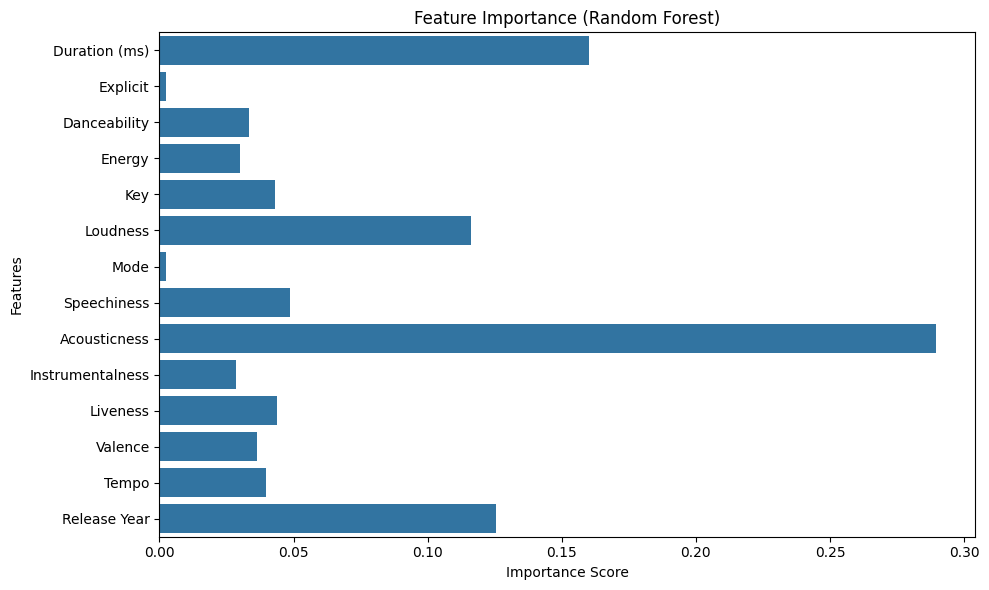

In [18]:
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [12]:
joblib.dump(rf, "rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


In [20]:
print(features)


['Duration (ms)', 'Explicit', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Release Year']


In [23]:
rf.fit(X, y)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
import joblib
joblib.dump(rf, "rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [1]:
# plot_feature_distributions.py
import os
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)
df = pd.read_csv("Spotify_data.csv")

features = ["Danceability", "Energy", "Valence", "Tempo", "Loudness"]
n = len(features)
fig, axes = plt.subplots(n, 1, figsize=(7, 2.2*n), constrained_layout=True)

for ax, feat in zip(axes, features):
    ax.hist(df[feat].dropna(), bins=30)
    ax.set_title(f"{feat} distribution")
    ax.set_xlabel(feat)
    ax.set_ylabel("Count")

plt.savefig("figures/feature_distributions.png", dpi=200)
plt.close()
print("Saved figures/feature_distributions.png")


Saved figures/feature_distributions.png


In [2]:
# plot_similarity_histogram.py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

os.makedirs("figures", exist_ok=True)
df = pd.read_csv("Spotify_data.csv")
FEATURES = ["Danceability","Energy","Valence","Tempo","Loudness",
            "Speechiness","Acousticness","Instrumentalness","Liveness"]
df = df.dropna(subset=FEATURES).reset_index(drop=True)

scaler = MinMaxScaler()
X = scaler.fit_transform(df[FEATURES])

# choose an example index (0), or find a popular song by index
idx = 0
sims = cosine_similarity(X[idx].reshape(1, -1), X).flatten()
# exclude self
sims = np.delete(sims, idx)

plt.figure(figsize=(7,4))
plt.hist(sims, bins=40)
plt.title("Cosine similarity distribution (example track)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.savefig("figures/similarity_histogram.png", dpi=200)
plt.close()
print("Saved figures/similarity_histogram.png")


Saved figures/similarity_histogram.png


In [4]:
# Load dataset again
df = pd.read_csv("Spotify_data.csv")

FEATURES = [
    "Danceability","Energy","Valence","Tempo","Loudness",
    "Speechiness","Acousticness","Instrumentalness","Liveness"
]

# Reload the model
import joblib
model = joblib.load("rf_model.pkl")

# Align feature importances with FEATURES length
importances = model.feature_importances_[:len(FEATURES)]

idx = np.argsort(importances)[::-1]
sorted_feats = [FEATURES[i] for i in idx]
sorted_imp = importances[idx]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(range(len(sorted_imp)), sorted_imp)
plt.xticks(range(len(sorted_imp)), sorted_feats, rotation=45, ha="right")
plt.title("Feature importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("figures/feature_importance_fixed.png", dpi=200)
plt.close()

print("Saved feature_importance_fixed.png")


Saved feature_importance_fixed.png
